## **Import Libraries**

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os

## **Unzip the dataset**

In [10]:
zip_path = r'C:\Users\Maged\Desktop\TASK 9\archive.zip'  # Replace with your ZIP file name
extract_path = 'ecommerce_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

## **Load CSV files**

In [12]:
customers_df = pd.read_csv(f'{extract_path}/olist_customers_dataset.csv')
orders_df = pd.read_csv(f'{extract_path}/olist_orders_dataset.csv')
order_items_df = pd.read_csv(f'{extract_path}/olist_order_items_dataset.csv')
payments_df = pd.read_csv(f'{extract_path}/olist_order_payments_dataset.csv')
products_df = pd.read_csv(f'{extract_path}/olist_products_dataset.csv')
sellers_df = pd.read_csv(f'{extract_path}/olist_sellers_dataset.csv')
category_translation_df = pd.read_csv(f'{extract_path}/product_category_name_translation.csv')

## **Check shape of datasets**

In [15]:
print(customers_df.shape)
print(orders_df.shape)
print(order_items_df.shape)
print(payments_df.shape)
print(products_df.shape)
print(sellers_df.shape)
print(category_translation_df.shape)

(99441, 5)
(99441, 8)
(112650, 7)
(103886, 5)
(32951, 9)
(3095, 4)
(71, 2)


## **Merge Datasets to Create Sales Data**

### **1.** Merge products with Category Names:

In [21]:
products_df = products_df.merge(category_translation_df, on='product_category_name', how='left')

### **2.** Merge Order Items with Products:

In [27]:
order_items_merged = order_items_df.merge(
    products_df[['product_id', 'product_category_name_english']],
    on='product_id', how='left')

### **3.** Merge with Orders Data:

In [30]:
order_items_merged = order_items_merged.merge(
    orders_df[['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp']],
    on='order_id', how='left')

### **4.** Merge to get payment details

In [35]:
order_items_merged = order_items_merged.merge(
    payments_df[['order_id', 'payment_type', 'payment_value']],
    on='order_id', how='left')

### **5.** Merge Customer Location:

In [38]:
order_items_merged = order_items_merged.merge(
    customers_df[['customer_id', 'customer_state']],
    on='customer_id', how='left')

### **6.** Format Date Column:

In [41]:
# Convert order_purchase_timestamp to datetime
order_items_merged['order_purchase_timestamp'] = pd.to_datetime(order_items_merged['order_purchase_timestamp'])

## **Analyze Sales & Revenue Trends.**

### **1.** Create Year-Month Column

In [55]:
# Create a Year-Month column for monthly analysis
order_items_merged['YearMonth'] = order_items_merged['order_purchase_timestamp'].dt.to_period('M')

### **2.** Group by Month: Total Orders & Revenue

In [57]:
# Group data monthly: number of orders and total revenue
monthly_sales = order_items_merged.groupby('YearMonth').agg({
    'order_id': 'nunique',   # Count of unique orders
    'price': 'sum'           # Total sales value
}).reset_index()

# Rename columns for clarity
monthly_sales.rename(columns={'order_id': 'total_orders', 'price': 'total_revenue'}, inplace=True)

###  **3.** Plot Monthly Revenue Trend

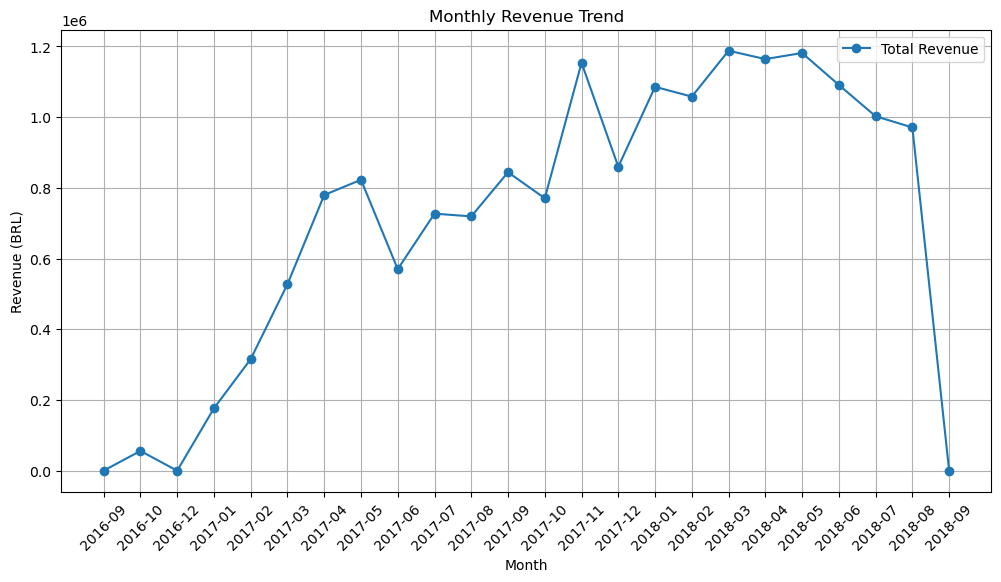

In [59]:
# Plot revenue trend over months
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(monthly_sales['YearMonth'].astype(str), monthly_sales['total_revenue'], marker='o', label='Total Revenue')
plt.xticks(rotation=45)
plt.title('Monthly Revenue Trend')
plt.xlabel('Month')
plt.ylabel('Revenue (BRL)')
plt.legend()
plt.grid(True)
plt.show()

## **Analyze Top-Selling Product Categories**

### Group by Product Category

In [62]:
# Group sales data by product category
category_sales = order_items_merged.groupby('product_category_name_english').agg({
    'price': 'sum',            # Total revenue per category
    'order_id': 'nunique'      # Number of orders per category
}).reset_index()

# Sort categories by total revenue
category_sales = category_sales.sort_values(by='price', ascending=False)

### Plot Top Categories by Revenue

C:\Users\Maged\AppData\Local\Temp\ipykernel_15980\2568587043.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_categories, x='price', y='product_category_name_english', palette='Blues_d')


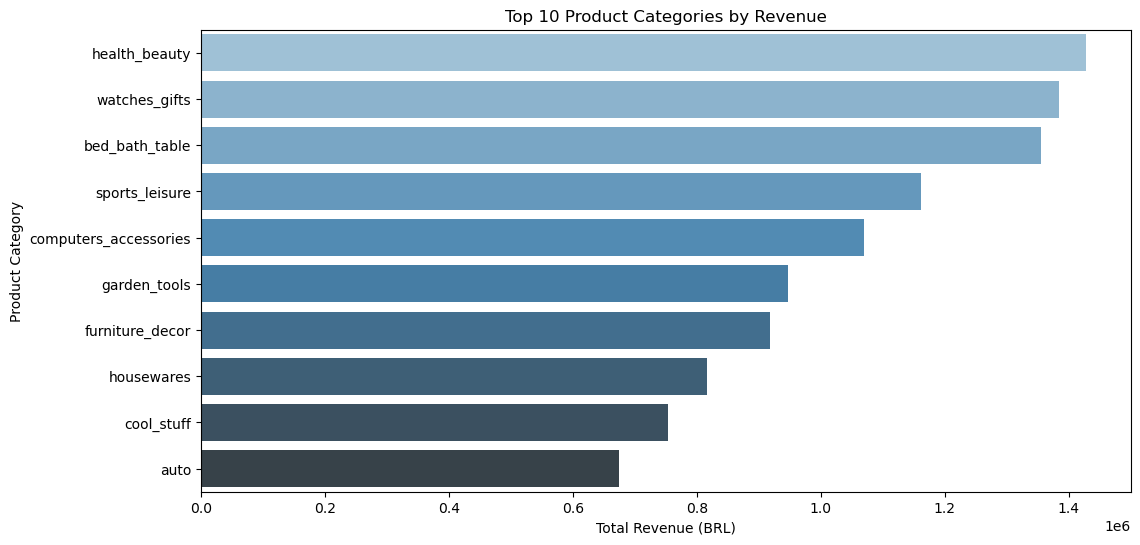

In [66]:
# Plot top 10 categories
top_categories = category_sales.head(10)

plt.figure(figsize=(12,6))
sns.barplot(data=top_categories, x='price', y='product_category_name_english', palette='Blues_d')
plt.title('Top 10 Product Categories by Revenue')
plt.xlabel('Total Revenue (BRL)')
plt.ylabel('Product Category')
plt.show()

## **Customer Distribution by State**

### Group by Customer State

In [70]:
# Group by state to see order distribution
state_sales = order_items_merged.groupby('customer_state').agg({
    'order_id': 'nunique',
    'price': 'sum'
}).reset_index()

# Rename columns for clarity
state_sales.rename(columns={'order_id': 'total_orders', 'price': 'total_revenue'}, inplace=True)

# Sort by revenue
state_sales = state_sales.sort_values(by='total_revenue', ascending=False)

### Plot Top States by Revenue

C:\Users\Maged\AppData\Local\Temp\ipykernel_15980\4124336737.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_states, x='total_revenue', y='customer_state', palette='Greens_d')


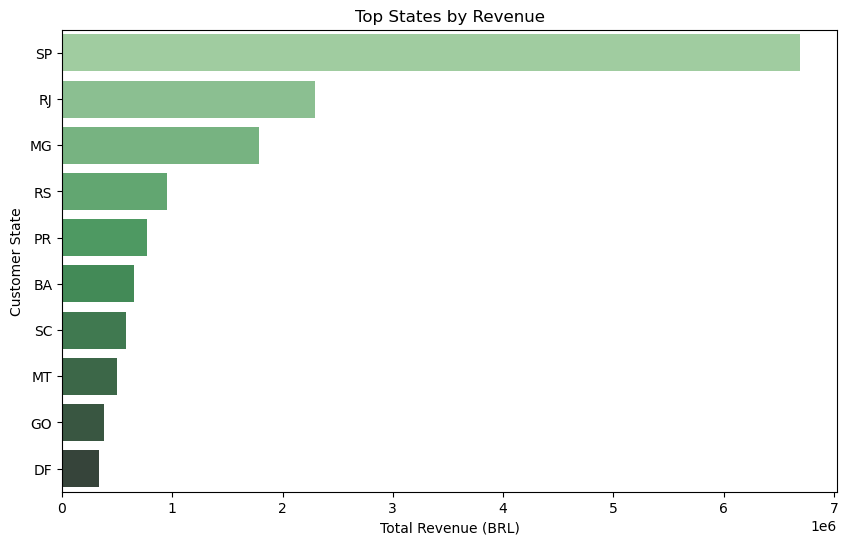

In [75]:
# Plot top 10 states by revenue
top_states = state_sales.head(10)

plt.figure(figsize=(10,6))
sns.barplot(data=top_states, x='total_revenue', y='customer_state', palette='Greens_d')
plt.title('Top States by Revenue')
plt.xlabel('Total Revenue (BRL)')
plt.ylabel('Customer State')
plt.show()

## **Export Key Dataframes as CSV (for Power BI)**

### Export Monthly Sales Summary

In [87]:
monthly_sales.to_csv('monthly_sales_summary.csv', index=False)

### Export Product Category Sales

In [85]:
category_sales.to_csv('category_sales_summary.csv', index=False)

### Export State-wise Sales

In [90]:
state_sales.to_csv('state_sales_summary.csv', index=False)


---